In [1]:
import pandas as pd 
import numpy as np
from time import time
import seaborn as sns

In [2]:
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import pyplot

import sys
import warnings
warnings.filterwarnings("ignore")

## Dataset

In this section we import our dataset (already processed and encoded) and check for correlated variables

The features we are interested in have to be as independent as possible from each other. Therefore, we are going to
make sure that we don't have any correlated columns with a value higher than .95

In [10]:
dataset = pd.read_csv(r'..\reports\Prueba.csv', index_col = 0)
dataset = dataset.drop(['home_GD_lm','away_GD_lm'], axis=1)

In [14]:
for col in ["season", "home_team", "away_team", "result"]:
    dataset[col] = dataset[col].astype("category")
    dataset[f"{col}_encoded"] = dataset[col].cat.codes

In [15]:
dataset

,season,division,matchday,home_team,away_team,result,season_encoded,home_team_encoded,away_team_encoded,result_encoded
0,1928,1,1,Arenas Club,Athletic Madrid,2,0,7,12,1
1,1928,1,1,Espanyol,Real Unión,1,0,68,116,0
2,1928,1,1,Real Madrid,Catalunya,1,0,110,56,0
3,1928,1,1,Donostia,Athletic,X,0,66,11,2
4,1928,1,1,Racing,Barcelona,2,0,103,23,1
...,...,...,...,...,...,...,...,...,...,...
48585,2021,2,3,Ponferradina,Girona,1,90,97,75,0
48586,2021,2,3,SD Amorebieta,UD Almería,1,90,121,137,0
48587,2021,2,3,CD Lugo,Real Valladolid,2,90,36,117,1
48588,2021,2,3,Real Sociedad B,CF Fuenlabrada,X,90,115,49,2


In [16]:
cor_matrix = dataset.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)  



[]


<AxesSubplot:>

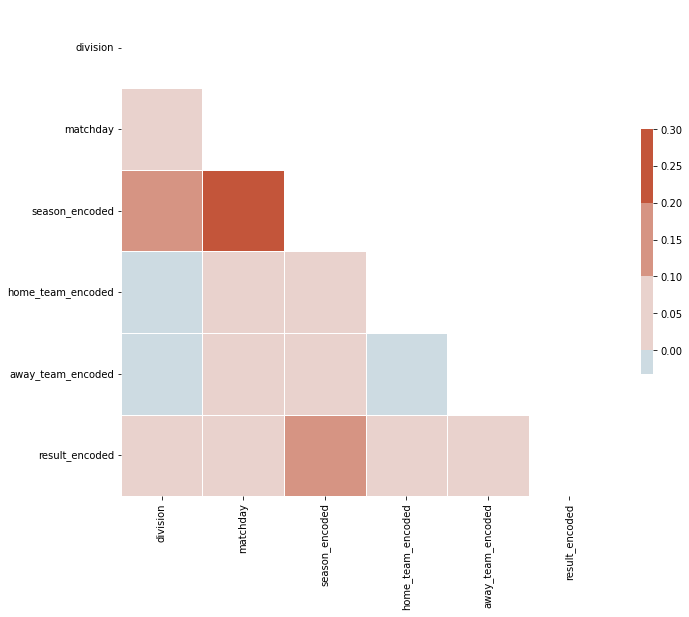

In [17]:
# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=False)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Automatic Variable Selection
In order to have an automatic variable selection we can use a **model-based** feature selection. Consequently, we will use a supervised machine learning model to judge the importance of each feature.

We will add some noise feature to our data and expect that the feature selection will identify the features that are non informative, removing the data features that are irrelevant.

For that purpose, we will add as many noise features as we have and select the 50% that are more correlated. Then, we will discard the noise features. The variables selected can be shown belove: black are original features and white noise features

X_train.shape: (36180, 5)
y_train.shape: (36180,)
X_train_l1.shape: (36180, 5)


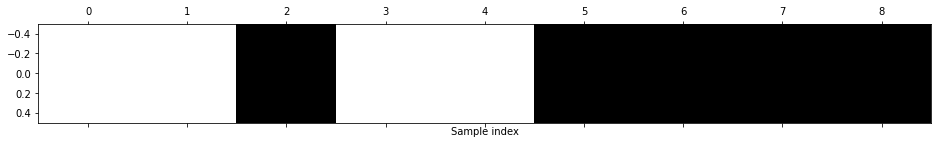

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

dataset = dataset.dropna()
target = dataset.result_encoded
X = dataset[['division','matchday','season_encoded','home_team_encoded','away_team_encoded']]
#target = dataset.result
#X = dataset.loc[:, dataset.columns != 'result']

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(dataset), 4))
X_w_noise = np.hstack([X, noise])

X_train,X_test,y_train,y_test = train_test_split(X_w_noise, target, test_size=0.25)

select = SelectFromModel( RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

select.fit(X_train, y_train)
X_train = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("y_train.shape: {}".format(y_train.shape))

print("X_train_l1.shape: {}".format(X_train.shape))

mask = select.get_support()
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")

X_test = select.transform(X_test)

## Normal selection of variables and splitting data

In [38]:
dataset = dataset.dropna()
target = dataset.result_encoded
X = dataset[['division','matchday','season_encoded','home_team_encoded','away_team_encoded']]
#X = dataset[['season','division','matchday','team','Away_team','W','GD_cum_before','rank_before']]
X_train,X_test,y_train,y_test = train_test_split(X, target, test_size=0.2, random_state=1)

## Function to construct confusion matrix and ROC

In [29]:
#plot our results
def confusion_matrix(trained_model, y_test, X_test):
    Y_test_pred = trained_model.predict(X_test)

    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        title="Confusion Matrix",
                                        cmap="Oranges",
                                        ax=ax1)

    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_confusion_matrix(y_test, Y_test_pred,
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        ax=ax2)

def ROC_PRC_matrix(trained_model, y_test, X_test):    
    y_test_probs = trained_model.predict_proba(X_test)
    
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    skplt.metrics.plot_roc_curve(y_test, y_test_probs,
                       title="Digits ROC Curve", figsize=(12,6), ax=ax1)
    
    ax2 = fig.add_subplot(122)
    skplt.metrics.plot_precision_recall_curve(y_test, y_test_probs,
                        title="Digits Precision-Recall Curve", figsize=(12,6), ax= ax2)

## Estimations of parameters in models

In [40]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X_train, y_train)
prediction_in = linear_svm.predict(X_train)
accuracy_r2_in = r2_score(y_train, prediction_in)
prediction_out = linear_svm.predict(X_test)
accuracy_r2_out = r2_score(y_test, prediction_out)
print() 
print("SVM") 
print("-" * 20)
print("Accuracy on training set: ",linear_svm.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
print("Accuracy on test set: ",linear_svm.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )


SVM
--------------------
Accuracy on training set:  0.4312551824212272 	R2 training set:  -1.2870061527840315
Accuracy on test set:  0.425787728026534 	R2 test set:  -1.3271594707385046


In [39]:
# Looking for best parameter for logistic regression model
for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(C=C).fit(X_train, y_train)
    prediction_in = logreg.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = logreg.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Logistic Regression with parameter ", C) 
    print("-" * 20)
    print("Accuracy on training set: ",logreg.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",logreg.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Logistic Regression with parameter  0.001
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Logistic Regression with parameter  0.01
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Logistic Regression with parameter  0.1
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Logistic Regression with parameter  1
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Logistic Regression with parameter  10
--------------------
Accuracy on training set:  0.527285447761194 	

In [31]:
# Preprunning for decision tree model, avoiding overfitting
for depth in range(3,8):
    tree = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    prediction_in = tree.predict(X_train)
    accuracy_r2_in = r2_score(y_train, prediction_in)
    prediction_out = tree.predict(X_test)
    accuracy_r2_out = r2_score(y_test, prediction_out)
    print() 
    print("Decision tree with depth ", depth) 
    print("-" * 20)
    print("Accuracy on training set: ",tree.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
    print("Accuracy on test set: ",tree.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Decision tree with depth  3
--------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Decision tree with depth  4
--------------------
Accuracy on training set:  0.5299803067993366 	R2 training set:  -0.7073791484896221
Accuracy on test set:  0.5280887230514096 	R2 test set:  -0.7081531844725697

Decision tree with depth  5
--------------------
Accuracy on training set:  0.5309131426202321 	R2 training set:  -0.7291712841130091
Accuracy on test set:  0.5296434494195689 	R2 test set:  -0.7292108044164145

Decision tree with depth  6
--------------------
Accuracy on training set:  0.533271144278607 	R2 training set:  -0.7093137936957186
Accuracy on test set:  0.5303689883913765 	R2 test set:  -0.7167809593106726

Decision tree with depth  7
--------------------
Accuracy on training set:  0.5360955638474295 	R2 training set:  -0.6926320416356049
Accuracy on test se

In [32]:
# Random forest model

# We set max_depth = 5 as preprunning parameter
# We set max_features as sqrt of n_features to reduce overfitting (pag 102)

for trees in range(5,10):
    for depth in range(2,6):
        random_forest = RandomForestClassifier(max_depth=depth, n_estimators=trees, max_features=3).fit(X_train, y_train)
        prediction_in = random_forest.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = random_forest.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(f"Random_forest with {trees} trees and {depth} depth") 
        print("-" * 40)
        print("Accuracy on training set: ",random_forest.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",random_forest.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )



Random_forest with 5 trees and 2 depth
----------------------------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Random_forest with 5 trees and 3 depth
----------------------------------------
Accuracy on training set:  0.527285447761194 	R2 training set:  -0.7482987197355464
Accuracy on test set:  0.5298507462686567 	R2 test set:  -0.7412019491066593

Random_forest with 5 trees and 4 depth
----------------------------------------
Accuracy on training set:  0.531224087893864 	R2 training set:  -0.7284047265785181
Accuracy on test set:  0.533271144278607 	R2 test set:  -0.7197056287473178

Random_forest with 5 trees and 5 depth
----------------------------------------
Accuracy on training set:  0.5308872305140961 	R2 training set:  -0.7357782800055268
Accuracy on test set:  0.5322346600331676 	R2 test set:  -0.7290645709445822

Random_forest with 6 trees and 


Logistic Regression
--------------------
Accuracy on training set:  0.52893864013267 	R2 training set:  -0.7421371998705968
Accuracy on test set:  0.5274184632393588 	R2 test set:  -0.7484688979760814

Decision Tree
--------------------
Accuracy on training set:  0.52893864013267 	R2 training set:  -0.7421371998705968
Accuracy on test set:  0.5274184632393588 	R2 test set:  -0.7484688979760814

Random Forest
--------------------
Accuracy on training set:  0.5334162520729685 	R2 training set:  -0.724806607167005
Accuracy on test set:  0.5295190713101161 	R2 test set:  -0.7352655792573282


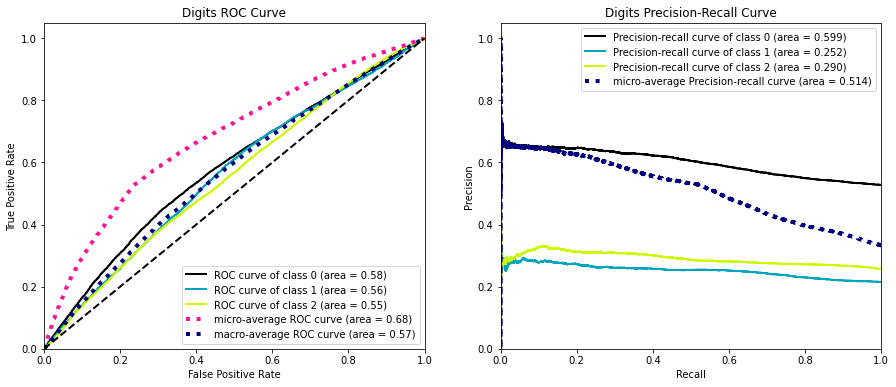

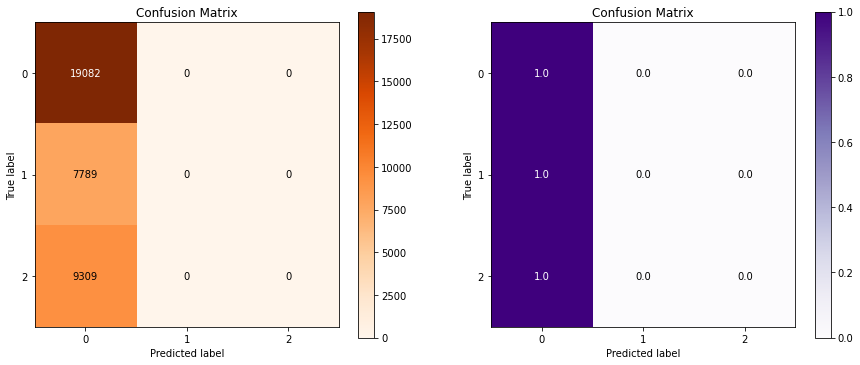

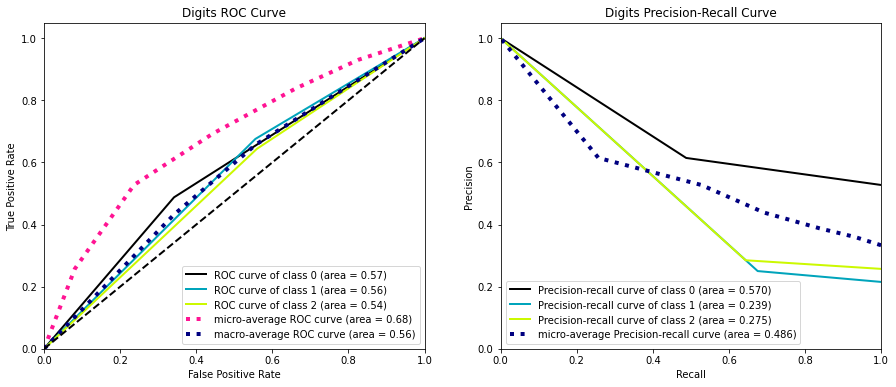

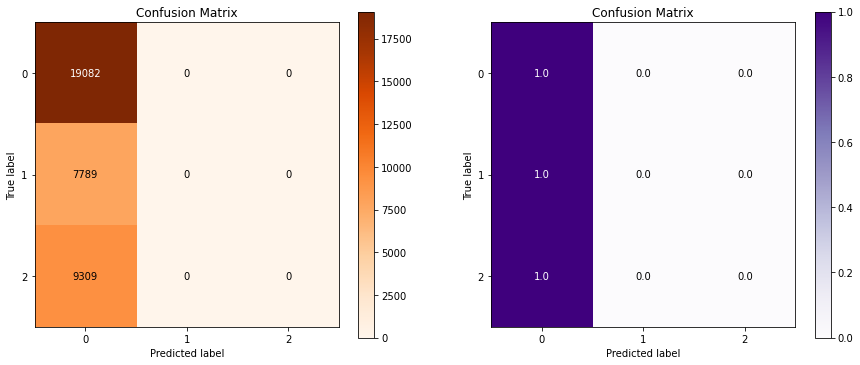

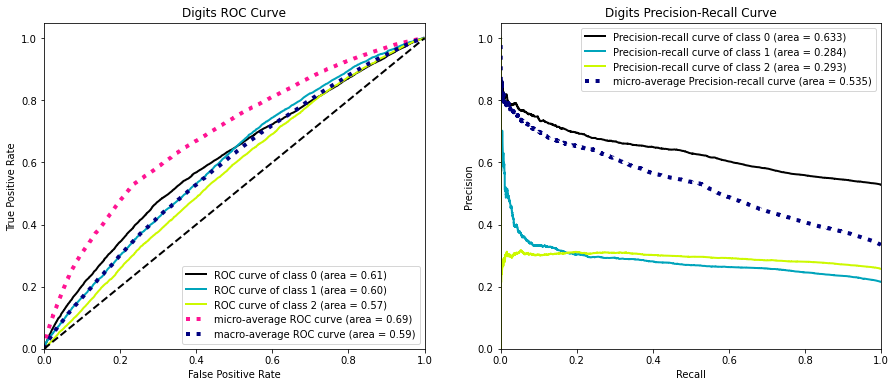

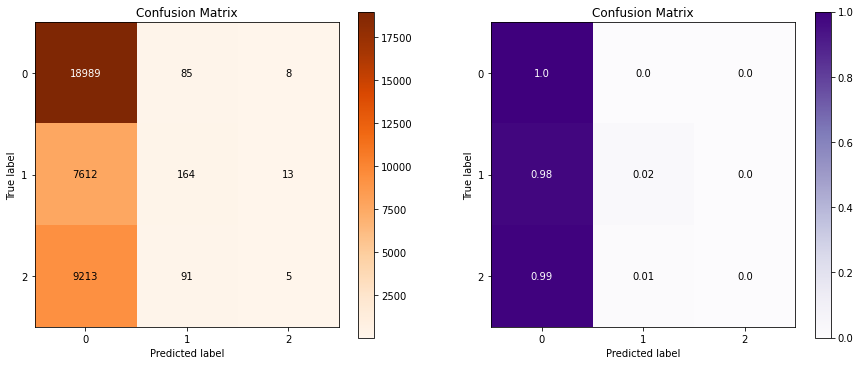

In [27]:
names = ["Logistic Regression", "Decision Tree", "Random Forest"]
         
classifiers = [
    #KNeighborsClassifier(3),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth=1),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
]


for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        prediction_in = clf.predict(X_train)
        accuracy_r2_in = r2_score(y_train, prediction_in)
        prediction_out = clf.predict(X_test)
        accuracy_r2_out = r2_score(y_test, prediction_out)
        print() 
        print(name) 
        print("-" * 20)
        print("Accuracy on training set: ",clf.score(X_train, y_train), "\tR2 training set: ", accuracy_r2_in )
        print("Accuracy on test set: ",clf.score(X_test, y_test), "\tR2 test set: ", accuracy_r2_out )
        ROC_PRC_matrix(clf, y_test, X_test)
        confusion_matrix(clf, y_test, X_test)
